In [1]:
import numpy as onp
import matplotlib.pyplot as plt

import jax.numpy as np 
from jax import grad, jit, vmap

from astropy.table import Table

from make_mask import *


import nrm_analysis as implaneia 
from nrm_analysis.misctools import mask_definitions
from nrm_analysis.misctools import oifits


%matplotlib inline

In [2]:
f2f,mask = mask_definitions.jwst_g7s6c()

barray, bls = makebaselines(mask)
triples, uvs = maketriples_all(mask)
w = np.sqrt(bls[:,0]**2 + bls[:,1]**2)
print('Longest Baseline %.2f m' % w.max())

Longest Baseline 5.28 m


Text(0, 0.5, 'v (m)')

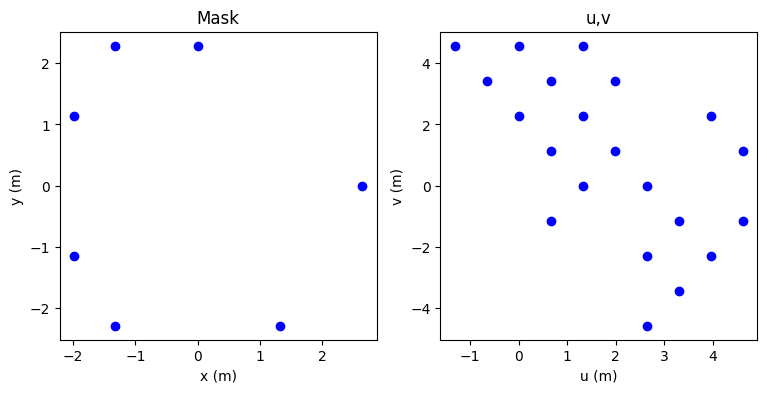

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9.0,4.0))

ax1.scatter(mask[:,0],mask[:,1],color='b')
ax1.set_title('Mask')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')


ax2.scatter(bls[:,0],bls[:,1],color='b')
ax2.set_title('u,v')
ax2.set_xlabel('u (m)')
ax2.set_ylabel('v (m)')


Now we are going to define functions for the discrete Fourier transform, giving us the 1-sided and 2-sided DFTM.

In [161]:
def compute_dftm1(x,y,uv,wavel):
    '''Compute a direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.'''

    # Convert to radians
    x = x * np.pi / 180.0 / 3600.0/ 1000.0
    y = y * np.pi / 180.0 / 3600.0/ 1000.0

    # get uv in nondimensional units
    uv = uv / wavel

    # Compute the matrix
    dftm = np.exp(-2j* np.pi* (np.outer(uv[:,0],x)+np.outer(uv[:,1],y)))

    return dftm

def apply_dftm1(image,dftm):
    '''Apply a direct Fourier transform matrix to an image.'''
    image /= image.sum()
    return np.dot(dftm,image.ravel())

In [162]:
pscale = 66 # mas/pixel
wavel = 4.3e-6 # m

# x = np.arange(80)*pscale - 80*pscale/2
x = np.arange(80)*pscale/10. - 80*pscale/2/10.
y = x.copy()
xx, yy = np.meshgrid(x,y)


dftm = compute_dftm1(xx, yy, bls, wavel)

In [275]:
u, v = np.linspace(-50,50,64), np.linspace(-50,50,64)

uu, vv = np.meshgrid(np.linspace(-50,50,64),np.linspace(-50,50,64))
uvgrid = np.vstack((uu.flatten(),vv.flatten())).T
dftm_test = compute_dftm1(xx, yy, uvgrid, wavel)

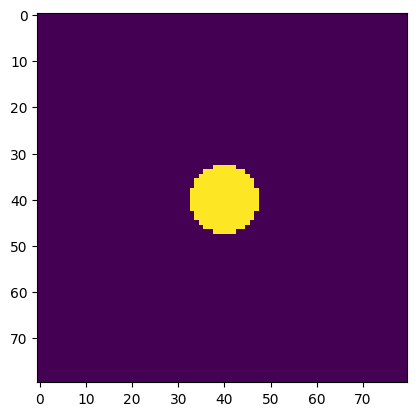

In [173]:
rr = np.sqrt(xx**2 + yy**2)
circular_star = 1.0*(rr<50)
plt.imshow(circular_star)

0.9619059860360795


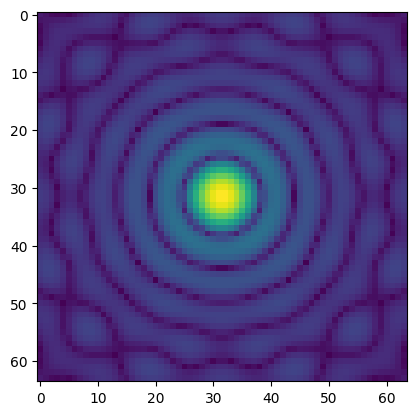

In [174]:
out = apply_dftm1(circular_star,dftm_test).reshape(64,64)
v2, phase = np.abs(out)**2, np.angle(out)
print(v2.max())
plt.imshow(v2**0.25)

In [175]:
from scipy.special import j1
mas2rad = np.pi / 180.0 / 3600.0/ 1000.0

def airy(uv, lam, diam):
    '''Airy function for a circular aperture, evaluated on baselines uv (m) with diameter diam (mas) at wavelength lam (m)'''
    
    r = np.sqrt(uv[:,0]**2 + uv[:,1]**2)/wavel

    d = diam*mas2rad

    return 2 * j1(np.pi * r * d) / (np.pi * r * d)

In [176]:
diam = 100 # mas
airy_disk = airy(uvgrid, wavel, diam)

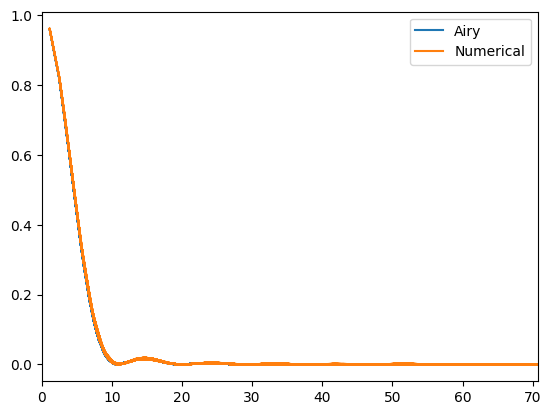

In [177]:
wgrid = np.sqrt(uvgrid[:,0]**2 + uvgrid[:,1]**2)

plt.plot(wgrid, airy_disk**2, label='Airy')
plt.plot(wgrid, v2.ravel(), label='Numerical')

plt.xlim(0,wgrid.max())
plt.legend()

Now let's do the 2-sided DFT method, which is valid only where you have a uniform grid in and out.

In [284]:
def compute_DFTM2(input_coordinates, output_coordinates, axis=0):
    '''
    Compute a 2-sided direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.

    Parameters
    ----------
    steps_in : tuple
        (x_step, y_step) in milliarcsec
    array_sizes : tuple
        (x_size, y_size) in pixels
    wavel : float
        Wavelength in metres
    pscale : float
        Pixel scale in milliarcsec
    axis : int
        Axis to compute DFTM along

    Returns
    -------
    ftm : 2D array
        One axis DFT matrix
    '''

    input_to_output = np.outer(input_coordinates, output_coordinates)

    ftm = np.exp(2. * np.pi * 1j * input_to_output)

    if axis != 0:
        return ftm
    else:
        return ftm.T

def both_DFTM2(u, v, img_size, wavel, pscale):
    '''Compute a 2-sided direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.
    
    Parameters
    ----------
    uv : 2D array
        Baselines in metres
    img_size : int
        Image size in pixels
    pscale : float
        Pixel scale in mas/pixel
    wavel : float
        Wavelength in metres
    
    Returns
    -------
    LL, RR : 2D arrays
        Left and Right DFT matrices
    '''

    # Compute the matrix
    output_coordinates = u/wavel

    input_coordinates = (np.arange(img_size) - img_size/2)*pscale*mas2rad

    LL = compute_DFTM2(input_coordinates, output_coordinates, axis=0)
    
    # Compute the other matrix
    output_coordinates = v/wavel
    input_coordinates = (np.arange(img_size) - img_size/2)*pscale*mas2rad

    RR = compute_DFTM2(input_coordinates, output_coordinates, axis=1)
    return LL, RR


def apply_dftm2(image,u, v, pscale, wavel):
    '''Apply a 2-sided direct Fourier transform matrix to an image.    

    Parameters
    ----------
    image : 2D array
        Image to be transformed
    uv : 2D array
        Baselines in metres
    pscale : float
        Pixel scale in mas/pixel
    wavel : float
        Wavelength in metres

    Returns
    -------
    FT : 2D array
        Fourier transform of the image
    '''

    image /= np.sum(image)

    img_size = image.shape[0]

    LL, RR = both_DFTM2(u, v, img_size, wavel, pscale)
    
    FT = np.dot(LL, np.dot(image, RR))

    return FT

In [289]:
twosided = apply_dftm2(circular_star, u, v, pscale/10., wavel)

v2_two, phase_two = np.abs(twosided)**2, np.angle(twosided)

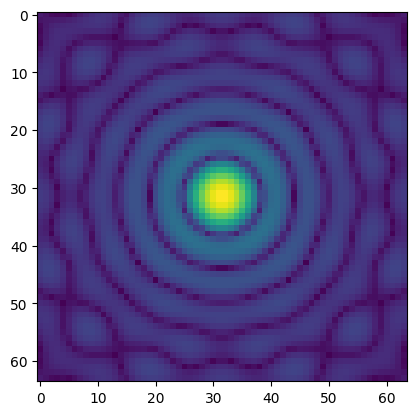

In [290]:
plt.imshow(v2_two**0.25)